In [ ]:
# install dependencies:
! pip install --upgrade optuna
! pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
! pip install cython pyyaml==5.1
! pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import wandb
from detectron2.config import get_cfg
import optuna


import matplotlib.pyplot as plt

def cv2_imshow(img):
    """Display an image using matplotlib."""
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide the axis values
    plt.show()


In [6]:
### improve the image using preprocessing
import os

# Define the image enhancement function
def enhance_image(input_path, output_path):
    # Load the image
    img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # 1. Noise Removal using Median Filter
    denoised_img = cv2.medianBlur(img_rgb, 5)

    # 2. Enhance Contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    denoised_img_gray = cv2.cvtColor(denoised_img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale for CLAHE
    contrast_enhanced_img_gray = clahe.apply(denoised_img_gray)
    contrast_enhanced_img = cv2.cvtColor(contrast_enhanced_img_gray, cv2.COLOR_GRAY2RGB)

    # 3. Sharpening using Unsharp Mask
    blurred = cv2.GaussianBlur(contrast_enhanced_img, (5,5), 0)
    sharpened = cv2.addWeighted(contrast_enhanced_img, 1.5, blurred, -0.5, 0)
    
    # Save the enhanced image
    cv2.imwrite(output_path, cv2.cvtColor(sharpened, cv2.COLOR_RGB2BGR))

# Main code to apply enhancement to each directory
directories = ["train", "test", "valid"]
for directory in directories:
    input_dir = f"/home/soham/oral_cancer/detectron2/combined_set/{directory}/images"  # Input directory (change this to your actual path)
    output_dir = f"/home/soham/oral_cancer/detectron2/enhanced_set/enhanced_{directory}"  # Output directory (change this if needed)
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through each image in the directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg"):  # Check for JPEG images (you can add more formats if needed)
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            enhance_image(input_path, output_path)

# Note: This code will not run here as I don't have access to the directories.
# You can run this code on your machine after setting the correct paths.



In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/soham/oral_cancer/detectron2/combined_set/train/output_coco_format_train.json", "/home/soham/oral_cancer/detectron2/enhanced_set/enhanced_train/")
register_coco_instances("my_dataset_val", {}, "/home/soham/oral_cancer/detectron2/combined_set/valid/output_coco_format_valid.json", "/home/soham/oral_cancer/detectron2/enhanced_set/enhanced_valid/")
register_coco_instances("my_dataset_test", {}, "/home/soham/oral_cancer/detectron2/combined_set/test/output_coco_format_test.json", "/home/soham/oral_cancer/detectron2/enhanced_set/enhanced_test/")


AssertionError: Dataset 'my_dataset_train' is already registered!

WARNING [09/11 16:41:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/11 16:41:23 d2.data.datasets.coco]: Loaded 1455 images in COCO format from /home/soham/oral_cancer/detectron2/combined_set/train/output_coco_format_train.json


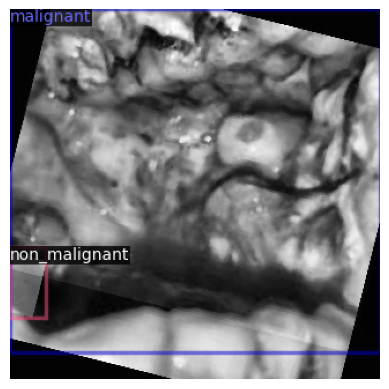

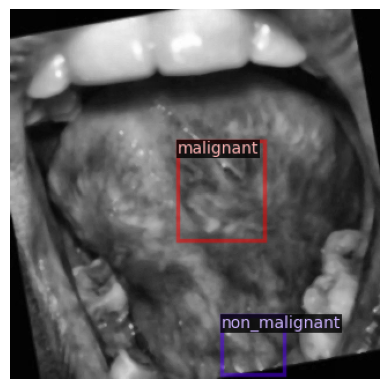

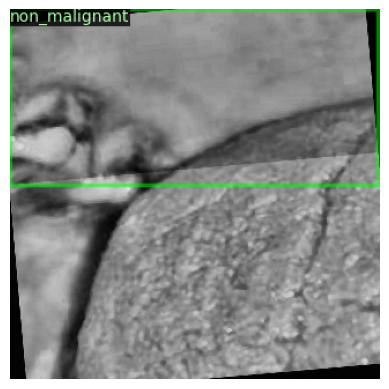

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [17]:
from optuna.integration.wandb import WeightsAndBiasesCallback


def objective(trial):
    # Start a new wandb run for each trial
    with wandb.init(project="detectron2_training_oralcancer", name=f"run-{trial.number}", sync_tensorboard=True):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
        cfg.DATASETS.TRAIN = ("my_dataset_train",)
        cfg.DATASETS.TEST = ("my_dataset_val",)
        cfg.DATALOADER.NUM_WORKERS = 4
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
        
        # Hyperparameters to optimize
        cfg.SOLVER.IMS_PER_BATCH = trial.suggest_int("IMS_PER_BATCH", 2, 8)
        cfg.SOLVER.BASE_LR = trial.suggest_float("BASE_LR", 1e-5, 1e-1, log=True)
        cfg.SOLVER.WARMUP_ITERS = trial.suggest_int("WARMUP_ITERS", 500, 2000)
        cfg.SOLVER.MAX_ITER = trial.suggest_int("MAX_ITER", 1000, 2000)
        cfg.SOLVER.STEPS = (trial.suggest_int("STEPS_1", 500, 1500),)
        cfg.SOLVER.GAMMA = trial.suggest_float("GAMMA", 0.01, 0.1)
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = trial.suggest_int("BATCH_SIZE_PER_IMAGE", 32, 64, 128)
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
        cfg.TEST.EVAL_PERIOD = 500
        
        # Log the config to wandb
        wandb.config.update({k: v for k, v in cfg.items()})

        os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        trainer = CocoTrainer(cfg)
        trainer.resume_or_load(resume=False)
        trainer.train()

        # Assuming the trainer returns validation loss; if not, replace this with your validation metric
        val_loss = trainer.validate()
        wandb.log({"validation_loss": val_loss})

        # Return the validation loss
        return val_loss

study = optuna.create_study(direction="minimize")

wandb_kwargs = {"project": "detectron2_training_oralcancer", "name": "optuna_study"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

study.optimize(objective, n_trials=30, callbacks=[wandbc])

# Log the best trial parameters and any other summary metrics outside of objective function
with wandb.init(**wandb_kwargs, name="optuna_study_summary"):
    print(f"Best trial: {study.best_trial.params}")
    wandb.log({"best_trial_params": study.best_trial.params})
    wandb.finish()


[I 2023-09-11 17:05:02,666] A new study created in memory with name: no-name-6ba6e5e1-8da9-4387-9a4a-1cc145a9d572
/tmp/ipykernel_660250/1279227103.py:43: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


[09/11 17:05:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[09/11 17:05:14 d2.engine.train_loop]: Starting training from iteration 0


/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [09/11 17:05:18 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 158, in forward
    features = self.backbone(images.tensor)
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/torch/nn/modules

Traceback (most recent call last):
  File "/tmp/ipykernel_660250/1279227103.py", line 31, in objective
    trainer.train()
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 484, in train
    super().train(self.start_iter, self.max_iter)
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/dete

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


data_time,▁
fast_rcnn/cls_accuracy,▁
fast_rcnn/false_negative,▁
fast_rcnn/fg_cls_accuracy,▁
global_step,▁
loss_box_reg,▁
loss_cls,▁
loss_rpn_cls,▁
loss_rpn_loc,▁
lr,▁
rank_data_time,▁


[W 2023-09-11 17:05:31,451] Trial 0 failed with parameters: {'IMS_PER_BATCH': 4, 'BASE_LR': 0.0002662539460117536, 'WARMUP_ITERS': 1957, 'MAX_ITER': 1064, 'STEPS_1': 1237, 'GAMMA': 0.08696335460273923, 'BATCH_SIZE_PER_IMAGE': 32} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 23.64 GiB total capacity; 5.96 GiB already allocated; 120.94 MiB free; 6.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_660250/1279227103.py", line 31, in objective
    trainer.train()
  File "/home/soham/.virtualenvs/detectron2/lib/python3.8/site-packages/detectron2/engine/defaults.py", 

OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 23.64 GiB total capacity; 5.96 GiB already allocated; 120.94 MiB free; 6.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# import optuna
# import wandb
# from optuna.integration import WandbCallback

# def objective(trial):
#     # Start a new wandb run for each trial
#     wandb.init(project="detectron2_training_oralcancer", name=f"run-{trial.number}", sync_tensorboard=True)
    
#     cfg = get_cfg()
#     cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
#     cfg.DATASETS.TRAIN = ("my_dataset_train",)
#     cfg.DATASETS.TEST = ("my_dataset_val",)
#     cfg.DATALOADER.NUM_WORKERS = 4
#     cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
    
#     # Hyperparameters to optimize
#     cfg.SOLVER.IMS_PER_BATCH = trial.suggest_int("IMS_PER_BATCH", 2, 8, 16, 32, 64)
#     cfg.SOLVER.BASE_LR = trial.suggest_float("BASE_LR", 1e-5, 1e-1, log=True)
#     cfg.SOLVER.WARMUP_ITERS = trial.suggest_int("WARMUP_ITERS", 500, 2000)
#     cfg.SOLVER.MAX_ITER = trial.suggest_int("MAX_ITER", 1000, 2000, 3000)
#     cfg.SOLVER.STEPS = (trial.suggest_int("STEPS_1", 500, 1000, 1500, 2000),)
#     cfg.SOLVER.GAMMA = trial.suggest_float("GAMMA", 0.01, 0.1)
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = trial.suggest_int("BATCH_SIZE_PER_IMAGE", 32, 128)
#     cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
#     cfg.TEST.EVAL_PERIOD = 500
    
#     # Log the config to wandb
#     wandb.config.update({k: v for k, v in cfg.items()})

#     os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#     trainer = CocoTrainer(cfg)
#     trainer.resume_or_load(resume=False)
#     trainer.train()

#     # Assuming the trainer returns validation loss; if not, replace this with your validation metric
#     val_loss = trainer.validate()

#     wandb.log({"validation_loss": val_loss})
    
#     # End the wandb run for this trial
#     wandb.finish()

#     # Return the validation loss
#     return val_loss

# # Create a study and optimize the objective
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=30, callbacks=[WandbCallback()])  # Adjust n_trials based on your preference

# print(f"Best trial: {study.best_trial.params}")


In [ ]:
# wandb.init(project="detectron2_training_oralcancer", name = "run-1" ,sync_tensorboard=True)

# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ("my_dataset_val",)
# cfg.DATALOADER.NUM_WORKERS = 4
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.001
# cfg.SOLVER.WARMUP_ITERS = 1000
# cfg.SOLVER.MAX_ITER = 1500
# cfg.SOLVER.STEPS = (1000,)
# cfg.SOLVER.GAMMA = 0.05
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
# cfg.TEST.EVAL_PERIOD = 500  

# # Log the config to wandb
# wandb.config.update({k: v for k, v in cfg.items()})

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = CocoTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

# # End the wandb run after training
# wandb.finish()


In [ ]:
    # test evaluation
    from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
    from detectron2.evaluation import COCOEvaluator, inference_on_dataset
    wandb.init(project='detectron2_training_oralcancer', name = "run-1",  resume=True)

    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
    predictor = DefaultPredictor(cfg)
    evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, "my_dataset_test")
    results = inference_on_dataset(trainer.model, val_loader, evaluator)

    # Log evaluation metrics to wandb
    wandb.log(results)


In [ ]:
ls ./output/

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
import cv2
from detectron2.utils.visualizer import Visualizer, ColorMode
import glob
import matplotlib.pyplot as plt

# Assuming you've already initialized `predictor` and `test_metadata` somewhere

for imageName in glob.glob('/content/test/*jpg'):
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Use matplotlib to display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
